# Algorithm scan

I'm attempting to see if I can "scan" the network weights in order to determine whether one of these 4 algorithm modes is present. This might be interesting in looking at training dynamics as well as providing a step towards being able to examine the emergence of similar algorithms with higher dimensional hidden layers (where visualisation is harder).

Properties:
- robust - to all variations of certain modes e.g. will be equivariant under switching of axes in this task
- soft - can maybe help me identify when there are mixtures of modes
- quick - fast to run (probably only important at larger scales)
- flexible - can apply it to various algorithms (again probably only important once there _are_ more algorithms) 
- scalable - can apply it to algorithms that are more complex than this one (probably not such a concern right now) 

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from pathlib import Path

from physics_mi.utils import set_all_seeds

MODELS = Path("models")

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
# seed = 2813536937  # found as training mode 3 through trial and error
seed = 620240165
set_all_seeds(seed)
print(seed)

620240165


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

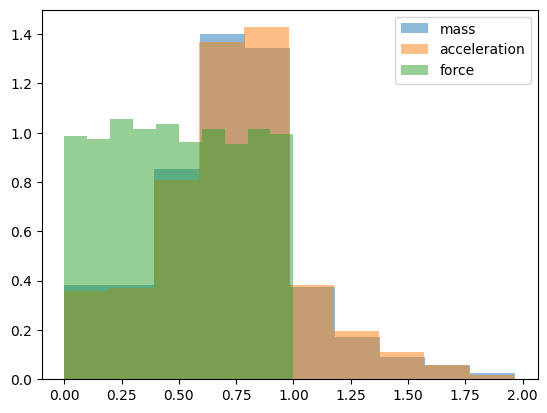

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-3)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

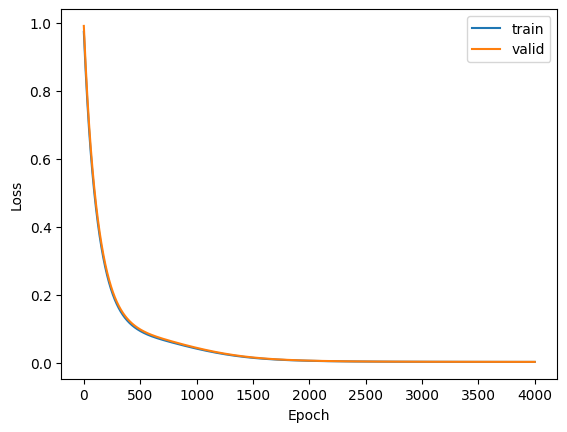

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0024)

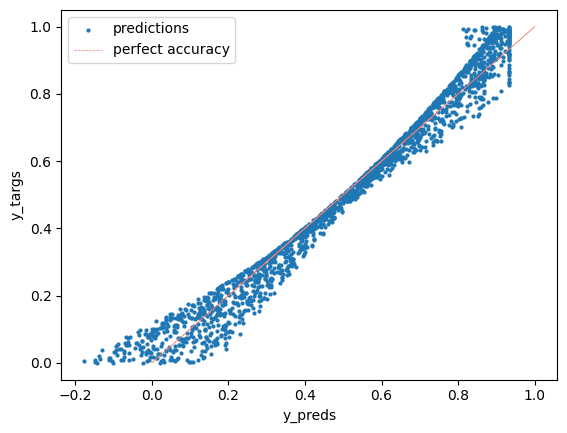

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[-0.5533, -0.6378],
        [-0.5059,  0.2349]]) 

layers.0.linear.bias 
 tensor([1.2146, 0.1266]) 

layers.1.linear.weight 
 tensor([[-1.1600, -0.3667]]) 

layers.1.linear.bias 
 tensor([0.9336]) 



### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [15]:
SD = model.state_dict()

In [16]:
from collections import OrderedDict


def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(
    x1,
    x2,
    ax=None,
    legend=True,
    color=None,
    product_color=False,
    point_selector={
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = OrderedDict()
    x["input"] = input
    x["prebias_preacts"] = prebias_preacts.flatten().tolist()
    x["preacts"] = preacts.flatten().tolist()
    x["acts"] = acts.flatten().tolist()
    x["prebias"] = [float(prebias), 0]
    x["output"] = [float(output), 0]

    markers = {}
    markers["input"] = "v"
    markers["prebias_preacts"] = "o"
    markers["preacts"] = "o"
    markers["acts"] = "o"
    markers["prebias"] = "o"
    markers["output"] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [17]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[-0.5533, -0.6378],
        [-0.5059,  0.2349]]) 

Result: 
 tensor([[-1.0528],
        [-0.1445]]) 

Bias: 
 tensor([1.2146, 0.1266]) 

Result: 
 tensor([ 0.1618, -0.0179]) 

Activations: 
 tensor([0.1618, 0.0000]) 

================ Layer 1 ================ 

Weight: 
 tensor([[-1.1600, -0.3667]]) 

Result: 
 tensor([-0.1877]) 

Bias: 
 tensor([0.9336]) 

Output: 
 tensor([0.7459]) 

y_true = 0.750


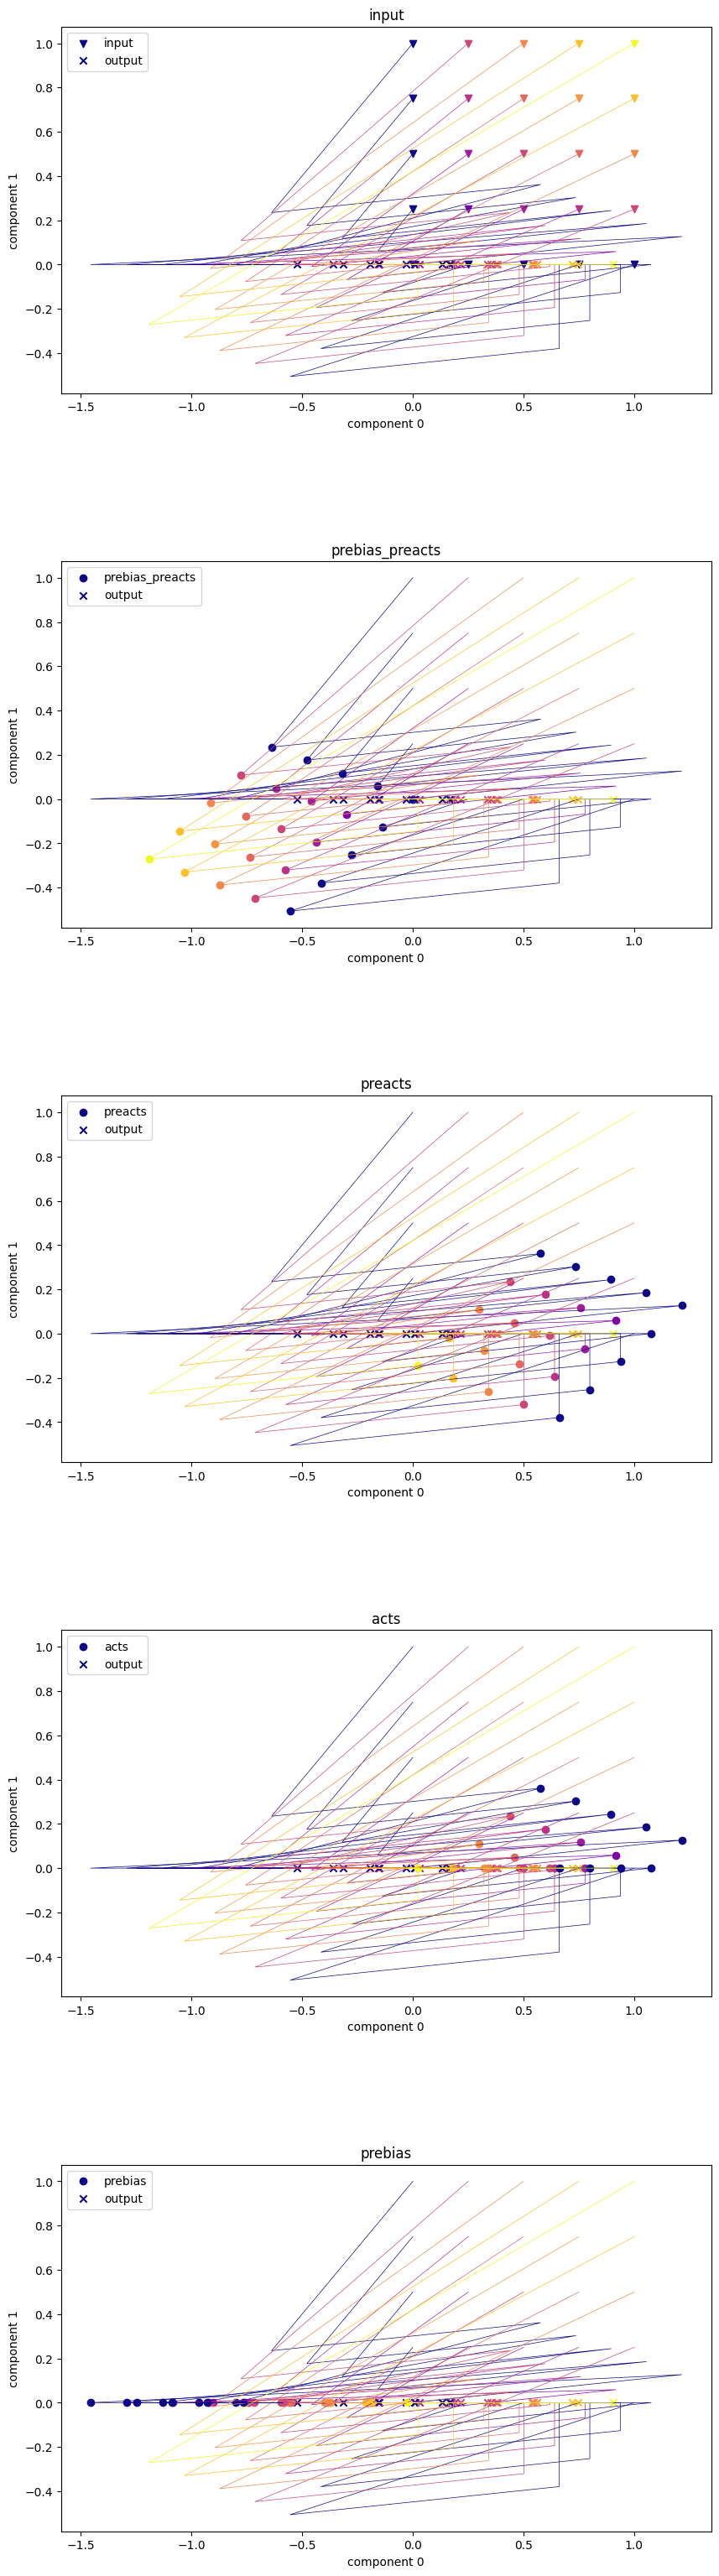

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(10, 40))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

# cols = get_colors(len(pairs))

subsets = [
    {
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": True,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": True,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": True,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": True,
        "output": True,
    },
]

titles = ["input", "prebias_preacts", "preacts", "acts", "prebias"]

for ax, subset, title in zip(axes.flatten(), subsets, titles):
    plot_model_breakdown(*pairs[0], ax, product_color=True, point_selector=subset)
    for pair in pairs[1:]:
        plot_model_breakdown(*pair, ax, legend=False, product_color=True, point_selector=subset)
    ax.set_title(title)
    ax.set_aspect("equal")

So I know for this mode at least I'm looking for a rotation + translation (and potentially some kind of shear that I might want to look for too) that results in the unit square sitting divided between the positive and negative sides of _one_ axis.

I guess in order to deal with the symmetry I _could_ create multiple "templates" to match and then just do some soft OR operation to see if either is activated, but this maybe isn't very scalable.

Potentially I could extract the overall rotated angle and see if this sits close to $\pm \frac{3 \pi}{4}$, meaning (provided the bias' translation in the relevant component is close to 0 - which we can also check) the unit square now sits astraddle an axis in the way we'd like?

If anything, the hidden linear transformation might give us all the information we need to decide (in this simple setting), which mode the network falls under. It is a necessary (but not sufficient) condition to prove the existence of a multiplication-like behaviour (I think?). To then distinguish it from being part of various other more complex algorithms that presumably exist in larger networks, I'm sure you'd need to ensure that all the steps are carried out (right up to and including that last bias operation to translate the results to the correct values).

I'll think about how one deals with the combinations later...

As an aside, it would be interesting to see whether these existed in larger networks trained in less constrained ways, because I'd imagine that multiplication could be a fundamental building block of many algorithms. I haven't yet thought about multi-layer networks though and whether the model would (probably) opt to distribute its computation of a multiplication operation across more layers to achieve a better loss 🙈 

I could just measure the angle between $(1,1)$ as input and its transformed output to extract this angle.

In [19]:
v1 = torch.tensor([1.0, 1.0])
v2 = torch.matmul(SD["layers.0.linear.weight"], v1)
v1, v2 = v1 / torch.norm(v1), v2 / torch.norm(v2)
theta = torch.acos(torch.dot(v1, v2)) / (3 * torch.pi / 4)
theta

tensor(1.0949)

Ok, so this works. To turn it into a score:

In [20]:
torch.sigmoid(1 - abs(1 - theta))

tensor(0.7120)

The other ingredient is the correct bias in the hidden layer. I will try and work out from `v2` which axis we are dealing with and therefore which component should be close to 0.

In [21]:
v2.argmin() == SD["layers.0.linear.bias"].argmax()

tensor(True)

So this statement should be true but maybe we can turn it into a soft measure since we know that network layers will have varying degrees of optimisation and therefore might not give a _perfect_ example of a certain algorithm but something in between.

As a general rule it's also nice to have soft measures because they will always provide more information than something binarised/quantised.

In [22]:
def bias_scan(v2, bias):
    """Returns score roughly representing how 'present' the mode 3 hidden layer bias is"""
    o1 = torch.softmax(-v2, 0)  # taking the -ve so that we align with the bias
    o2 = torch.softmax(bias, 0)
    return torch.dot(o1 / torch.norm(o1), o2 / torch.norm(o2))


def bias_scan_binary(v2, bias):
    """Binary version of the bias scan: checking for presence of the mode 3 hidden layer bias"""
    return v2.argmin() == SD["layers.0.linear.bias"].argmax()

In [23]:
bias_scan(v2, SD["layers.0.linear.bias"])

tensor(0.9934)

In [24]:
negative_scores = [bias_scan(torch.rand(2) * 2 - 1, torch.rand(2) * 2 - 1) for i in range(1000)]
negative_scores = torch.stack(negative_scores)

In [25]:
bias_scan(v2, SD["layers.0.linear.bias"]).numpy()[None]

array([0.9933834], dtype=float32)

(0.5, 1.0)

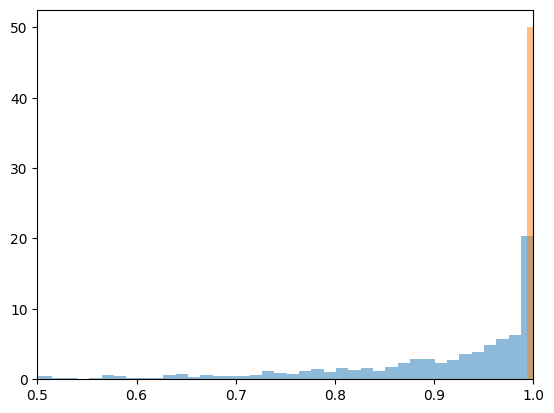

In [26]:
fig, ax = plt.subplots()
ax.hist(negative_scores.numpy(), bins=50, density=True, alpha=0.5)
ax.hist(bias_scan(v2, SD["layers.0.linear.bias"]).numpy()[None], bins=50, density=True, alpha=0.5)
ax.set_xlim(0.5, 1)

In [27]:
(bias_scan(v2, SD["layers.0.linear.bias"]) > negative_scores).numpy().mean()

0.809

So it seems that random tensors score higher than the true signal > 15% of the time, which isn't great _but_ potentially to be expected because it's not a very strong test.

In [28]:
negative_scores = [bias_scan_binary(torch.rand(2) * 2 - 1, torch.rand(2) * 2 - 1) for i in range(1000)]
negative_scores = torch.stack(negative_scores)
negative_scores.numpy().mean()

0.505

The binary test is activated 50% of the time at random (which makes sense) so at least the soft score seems to be an improvement there.

The final piece to think about is the output linear layer. I think we'd like to see values that are higher on the _active axis_ (the axis on which the ReLU projection is active) translated to lower negative values, therefore, the corresponding component should be negative. The other component should also be negative as it's using the +ve magnitude in the orthogonal component to learn something more about the negativity.

The magnitude of the active axis component seems often be greater than the secondary component but I think I shall ignore that for now because it might overcomplicate.

In [29]:
def final_layer_weight_scan(weight):
    return torch.sigmoid(-weight).mean()

In [30]:
negative_scores = [final_layer_weight_scan(torch.rand(2) * 2 - 1) for _ in range(1000)]
negative_scores = torch.stack(negative_scores)

In [31]:
(final_layer_weight_scan(SD["layers.1.linear.weight"]) > negative_scores).numpy().mean()

0.978

This is pretty good.

Finally, we know that the bias should be positive. Something really simple:

In [32]:
def final_bias_scan(bias):
    return torch.sigmoid(bias).mean()


final_bias_scan(SD["layers.1.linear.bias"])

tensor(0.7178)

### Combining

Now this issue has been on the horizon for a little while now... How does one really rigorously define "how algorithm-y an algorithm is"?

At this stage I'm thinking about weighting the scores together but there's a lot of human judgement involved in that. I'm sure if I put my mind to it I could come up with something more beautiful (e.g. casting all the parameters to a space with symmetry in the algorithm space and then doing cosine similarity or something) but this is my ugly POC (so don't @ me).

I'm just going to weight each score based on how many parameters their corresponding element has (ignoring the fact that my scores are all scaled differently anyway 🙈). I'm hoping that somehow the components with more parameters are somehow more important (which they aren't necessarily).

In [33]:
def mode_3_score(SD):
    scores = {}

    layer = "layers.0.linear.weight"
    v1 = torch.tensor([1.0, 1.0])
    v2 = torch.matmul(SD[layer], v1)
    v1, v2 = v1 / torch.norm(v1), v2 / torch.norm(v2)
    theta = torch.acos(torch.dot(v1, v2)) / (3 * torch.pi / 4)
    scores[layer] = {}
    scores[layer]["score"] = float(torch.sigmoid(1 - abs(1 - theta)))
    scores[layer]["n"] = SD[layer].flatten().shape[0]

    layer = "layers.0.linear.bias"
    o1 = torch.softmax(-v2, 0)  # taking the -ve so that we align with the bias
    o2 = torch.softmax(SD[layer], 0)
    scores[layer] = {}
    scores[layer]["score"] = float(torch.dot(o1 / torch.norm(o1), o2 / torch.norm(o2)))
    scores[layer]["n"] = SD[layer].flatten().shape[0]

    layer = "layers.1.linear.weight"
    scores[layer] = {}
    scores[layer]["score"] = float(torch.sigmoid(-SD[layer]).mean())
    scores[layer]["n"] = SD[layer].flatten().shape[0]

    layer = "layers.1.linear.bias"
    scores[layer] = {}
    scores[layer]["score"] = float(torch.sigmoid(SD[layer]).mean())
    scores[layer]["n"] = SD[layer].flatten().shape[0]

    df = pd.DataFrame(scores).T

    score = ((df["n"] / df["n"].sum()) * df["score"]).sum()  # weighting according to number of parameters

    return score

I'm sorry that's a disgusting function but I'm extremely keen not to over-engineer here.

In [34]:
df = mode_3_score(SD)
df

0.7671682238578796

### Simple evaluation

The simplest evaluation I can think of is generating various randomly initialised networks as negative examples. That's one step behind the better evaluation of actually training the network to give realistic weights (and examine how well the model distinguishes between the different modes).

**NOTE:** the models I'm loading below were trained using the `train.py` script - feeding in the seeds that I manually found to produce clean mode 3 behaviour in experiment 9. Again, this workflow isn't perfect because this doesn't represent a final evaluation, more just to give some kind of idea.

In [35]:
N = 2000
negative_scores = []
for _ in range(N):
    model = Net(use_act=True, dim=2)
    score = mode_3_score(model.state_dict())
    negative_scores.append(score)

# using only the two examples we have right now...
positive_scores = []
for fn in ("e10-620240165.pth", "e10-2813536937.pth"):
    SD = torch.load(MODELS / fn)
    score = mode_3_score(SD)
    positive_scores.append(score)

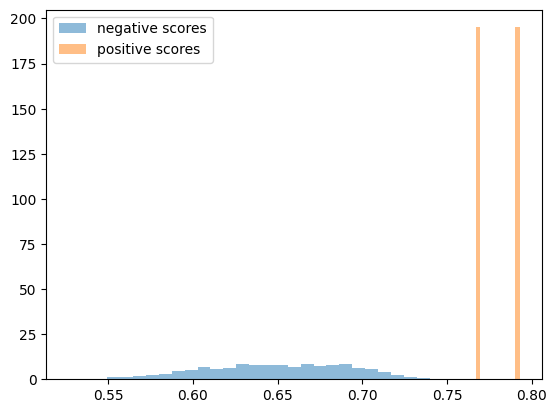

In [36]:
fig, ax = plt.subplots()

ax.hist(negative_scores, alpha=0.5, bins=30, density=True, label="negative scores")
ax.hist(positive_scores, alpha=0.5, density=True, label="positive scores")
ax.legend()

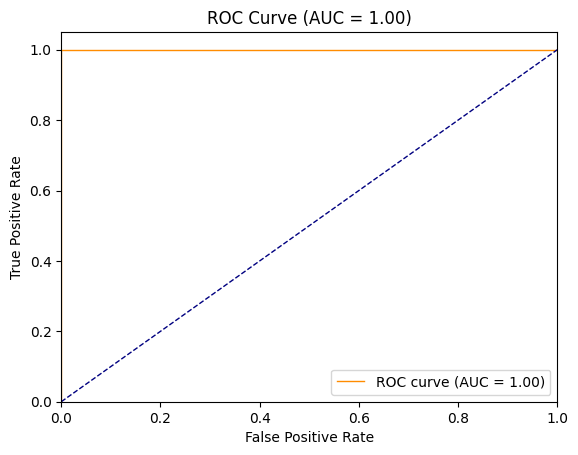

In [38]:
from sklearn.metrics import roc_curve, auc

# Combine the scores and create labels
scores = negative_scores + positive_scores
labels = [0] * len(negative_scores) + [1] * len(positive_scores)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=1, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.legend(loc="lower right")
plt.show()

Ok I mean that seems to work ok. Like I said though, we'd need to evaluate against trained models (in the other modes) for this to be proven useful. 

### Alternative scan ideas

I'm generally not a fan of this approach that I've developed. It's far too hand-crafted with plenty of arbitrary design choices that are likely to lead to inductive bias. Some other ideas that could be more general: 

1. I suppose a simple method to detect these algorithms/circuits is to see whether... they carry out a multiplication faithfully 😅 The value of the loss against a simple $x_1 \cdot x_2$ regression task is also likely to be a good indicator of which mode is present (if any).
2. I could create a small dataset from a sample of e.g. 100 randomly sampled (trained) networks and train a single linear classifier on the parameters to predict the mode. This is much more along the lines of a linear probe but has various downsides (e.g. having to collect and label the dataset - with the human error involved there). The plus side is that it would be lightweight and probably efficient.

### Options for what I should look at next

1. Try another scanning function idea (like one of the ones above)
1. Apply my existing one to better evaluation data and understand things like: how well it actually works in practice, what proportion of trained models end up as mode 3, whether I can see the appearance of mode 3 as I'm optimising the model.

Or I could leave the idea of algorithm scans and move onto:
1. Increasing the dimension of the hidden layer
1. Increasing the number of hidden layers
1. Looking at division

Thinking about algorithm scans in more complex networks leaves me with a few possible questions:
- surely the computational complexity of the scan will increase $O(X^2)$ with the dimension of the layer as any number could potentially be multiplied with another so you'd have to try all combinations?
- I'd imagine multiple-layered networks might start distributing the multiplication operation across all of their layers for better performance - this would complicate the picture (although I can imagine some of the recent circuit search literature could help)

With this in mind, I think it might make sense to look at multi-layered networks next (still with 2 hidden dimensions so I can visualise easily). Let's see what I feel like tomorrow.